<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/kaggle_car_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install joblib

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

import joblib

pd.set_option('future.no_silent_downcasting', True)  # 忽略replace()方法的future warning downcasting 行為


In [3]:
data = pd.read_csv("/content/sample_data/train.csv", encoding="utf-8")
display(data.info())
display(data.shape)
display(data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

None

(58592, 44)

Index(['policy_id', 'policy_tenure', 'age_of_car', 'age_of_policyholder',
       'area_cluster', 'population_density', 'make', 'segment', 'model',
       'fuel_type', 'max_torque', 'max_power', 'engine_type', 'airbags',
       'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'displacement', 'cylinder',
       'transmission_type', 'gear_box', 'steering_type', 'turning_radius',
       'length', 'width', 'height', 'gross_weight', 'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim'],
      dtype='object')

In [ ]:
# 查看缺失值及重覆值
display(data.isna().sum())
display(data.duplicated().sum())

,0
policy_id,0
policy_tenure,0
age_of_car,0
age_of_policyholder,0
area_cluster,0
population_density,0
make,0
segment,0
model,0
fuel_type,0


0

In [6]:
# 目標變數為欄位is_claim ，屬於二元分類問題。
# 檢視目標變數的值為0, 1 的比例
display(data["is_claim"].value_counts())
display(data["is_claim"].value_counts(normalize=True))

,count
is_claim,
0,54844
1,3748


,proportion
is_claim,
0,0.936032
1,0.063968


In [ ]:
# 檢查object欄位的唯一值數量及唯一值

for col in data.columns:
  if data[col].dtype == "object":
    unique = data[col].unique()
    print(f"欄位名稱: {col}, 唯一值數量: {len(unique)}")
    print(unique)


欄位名稱: policy_id, 唯一值數量: 58592
['ID00001' 'ID00002' 'ID00003' ... 'ID58590' 'ID58591' 'ID58592']
欄位名稱: area_cluster, 唯一值數量: 22
['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22']
欄位名稱: segment, 唯一值數量: 6
['A' 'C1' 'C2' 'B2' 'B1' 'Utility']
欄位名稱: model, 唯一值數量: 11
['M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'M10' 'M11']
欄位名稱: fuel_type, 唯一值數量: 3
['CNG' 'Petrol' 'Diesel']
欄位名稱: max_torque, 唯一值數量: 9
['60Nm@3500rpm' '113Nm@4400rpm' '91Nm@4250rpm' '250Nm@2750rpm'
 '200Nm@3000rpm' '82.1Nm@3400rpm' '200Nm@1750rpm' '85Nm@3000rpm'
 '170Nm@4000rpm']
欄位名稱: max_power, 唯一值數量: 9
['40.36bhp@6000rpm' '88.50bhp@6000rpm' '67.06bhp@5500rpm'
 '113.45bhp@4000rpm' '88.77bhp@4000rpm' '55.92bhp@5300rpm'
 '97.89bhp@3600rpm' '61.68bhp@6000rpm' '118.36bhp@5500rpm']
欄位名稱: engine_type, 唯一值數量: 11
['F8D Petrol Engine' '1.2 L K12N Dualjet' '1.0 SCe' '1.5 L U2 CRDi'
 '1.5 Turbocharged Revotorq' 'K Series Dual jet' '1.2 L K Series Engine'
 'K10C' 

In [ ]:
# 檢查布林欄位
for col in data.columns:
  if "is_" in col:
    print(data[col].unique())


['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
[0 1]


In [7]:
# 刪除不必要欄位
df = data.drop(columns=["policy_id"])

In [8]:
# 處理max_torque, max_power 欄位
df["max_torque"] = df["max_torque"].str.lower()
df["max_torque"]
def torque_transform(torque):
  return torque.split("n")[0]
df["max_torque"] = df["max_torque"].apply(torque_transform)
df["max_torque"].value_counts()

df["max_power"] = df["max_power"].str.lower()
def power_transform(power):
  return power.split("b")[0]
df["max_power"] = df["max_power"].apply(power_transform)


In [30]:
# 分別提取特徵、標籤

X = df.drop(columns=["is_claim"])
y = df["is_claim"]
X.columns

# 分割取得測試集、訓練集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


In [32]:
# 特徵分類

binary_feature = []
for f in X.columns:
  if "is_" in f:
    binary_feature.append(f)
print(binary_feature)

unchanged_feature = ["policy_tenure", "age_of_car", "age_of_policyholder"]
frequency_feature = ["area_cluster", "model", "engine_type"]
num_feature = ["population_density", "make", "max_torque", "max_power",
               "airbags", "displacement", "cylinder", "gear_box",
               "turning_radius", "length", "width", "height", "gross_weight", "ncap_rating"]
cat_feature = ["segment", "fuel_type", "rear_brakes_type", "transmission_type",
               "steering_type"]
print(len(binary_feature) + len(unchanged_feature) +
      len(frequency_feature) + len(num_feature) + len(cat_feature)) # 確認欄位數量


['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']
42


In [49]:
# 設置預處理

# 設置二位元特徵轉換
def binary_map(binary_df):
  # print(binary_df) # 由ColumnTransformer()傳進來的是dataframe
  for col in binary_df.columns:
    binary_df[col] = binary_df[col].str.lower().replace({"yes": 1, "no":0}).astype("int32")
  return binary_df

# 設置頻率編碼轉換
def frequency_map(frequency_df):
  # print(frequency_df) # 由ColumnTransformer()傳進來的是dataframe
  for col in frequency_df:
    frequency_df[col] = frequency_df[col].map(frequency_df[col].value_counts())
  return frequency_df

# 設置頻率特徵pipeline
frequency_pipeline = Pipeline(steps=[
    ("frequency_enc", FunctionTransformer(func=frequency_map, validate=False)),
    ("scaler", MinMaxScaler())
])
# 設置欄位轉換器
preprocessor = ColumnTransformer(transformers=[
    ("binary", FunctionTransformer(func=binary_map, validate=False), binary_feature),
    ("passthrough", "passthrough", unchanged_feature),
    ("frequency", frequency_pipeline, frequency_feature),
    ("num", MinMaxScaler(), num_feature),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_feature)
])

# 設置預處理器及分類器pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classfier", RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"))
])

# display(X_train.head(3))
# display(y_train.head(3))
display(X_train.shape, X_test.shape)
display(y_train.shape, y_test.shape)
display(y_train.value_counts())


(46873, 42)

(11719, 42)

(46873,)

(11719,)

,count
is_claim,
0,43875
1,2998


In [50]:
# 執行測試集及訓練集的預處理擬合及轉換
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
display(X_train_preprocessed.shape, X_test_preprocessed.shape)

# # 取得有經過ohe編碼的類別名稱，返回的是numpy一維組組
# ohe_feature = list(preprocessor.named_transformers_["cat"].get_feature_names_out())
# print(ohe_feature)
# # 整合重組回dataframe
# all_feature_name = binary_feature + unchanged_feature + frequency_feature + num_feature + ohe_feature
# X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_name)
# X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_name)

# display(X_train_preprocessed_df.head(3))
# display(X_train_preprocessed_df.shape)
# display(X_test_preprocessed_df.shape)
# X_train_preprocessed_df.info()


(46873, 53)

(11719, 53)

In [51]:
# SMOTE 之前的類別分佈
print("SMOTE 之前類別分佈:", Counter(y_train))

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# SMOTE 之後的類別分佈
print("SMOTE 之後類別分佈:", Counter(y_train_smote))

SMOTE 之前類別分佈: Counter({0: 43875, 1: 2998})
SMOTE 之後類別分佈: Counter({0: 43875, 1: 43875})


In [52]:
# 訓練模型
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)


RandomForestClassifier(random_state=42)

In [53]:
# 測試模型
y_smote_pred = model_smote.predict(X_test_preprocessed)

In [54]:
print("Accuracy:", accuracy_score(y_test, y_smote_pred))

Accuracy: 0.7962283471285946


In [55]:
print(classification_report(y_test, y_smote_pred))


              precision    recall  f1-score   support

           0       0.94      0.84      0.88     10969
           1       0.09      0.23      0.13       750

    accuracy                           0.80     11719
   macro avg       0.51      0.53      0.50     11719
weighted avg       0.89      0.80      0.84     11719



Text(0.5, 1.0, 'Confusion Matrix')

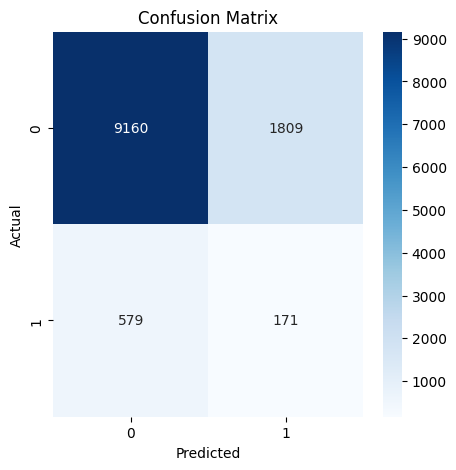

In [56]:
cm = confusion_matrix(y_test, y_smote_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [40]:
# 對訓練集數據進行擬合產生模型並儲存模型
model.fit(X_train, y_train)

joblib.dump(model, "trained_randomforestclassfier.pkl")

['trained_randomforestclassfier.pkl']

In [41]:
print(type(model))
print(model.named_steps["classfier"])
feature_importances = model.named_steps["classfier"].feature_importances_
print(len(feature_importances))
print(feature_importances)
display(model)

<class 'sklearn.pipeline.Pipeline'>
RandomForestClassifier(class_weight='balanced', random_state=42)
53
[2.87899279e-04 2.29576052e-04 9.18482297e-05 1.75120299e-04
 2.67241623e-04 2.19708014e-04 2.34373787e-04 2.23099181e-04
 2.59644602e-04 3.26009129e-04 1.60959801e-04 3.73325589e-04
 9.20341588e-05 1.88709295e-04 2.74294629e-04 2.12853821e-04
 7.34994549e-05 3.93928586e-01 1.90976264e-01 2.59432977e-01
 6.80088016e-02 1.31513293e-03 1.17321793e-03 6.75268578e-02
 4.40172942e-04 9.87256434e-04 7.86005187e-04 3.09876674e-04
 1.33705443e-03 4.02539986e-04 7.27926561e-05 7.05294121e-04
 1.25089596e-03 9.56147828e-04 1.35398280e-03 1.01894482e-03
 8.87666876e-04 4.06915101e-04 2.31585598e-04 3.44360654e-04
 2.31952289e-04 6.55262066e-05 7.08219637e-05 1.90833191e-04
 1.51681580e-04 2.87795232e-04 1.39255502e-04 1.04479651e-04
 3.07262158e-04 3.14262600e-04 2.91391281e-04 9.81854959e-05
 2.03025911e-04]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function binary_map at 0x7d3a87753b00>),
                                                  ['is_esc',
                                                   'is_adjustable_steering',
                                                   'is_tpms',
                                                   'is_parking_sensors',
                                                   'is_parking_camera',
                                                   'is_front_fog_lights',
                                                   'is_rear_window_wiper',
                                                   'is_rear_window_washer',
                                                   'is_rear_window_defogger',
                                                   'is_brake_assist',
                                                   'is_power_door...
                                                   'max_torque', 'max_power',
                                                   'airbags', 'displacement',
                                                   'cylinder', 'gear_box',
                                                   'turning_radius', 'length',
                                                   'width', 'height',
                                                   'gross_weight',
                                                   'ncap_rating']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['segment', 'fuel_type',
                                                   'rear_brakes_type',
                                                   'transmission_type',
                                                   'steering_type'])])),
                ('classfier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [42]:
# 載入訓練好的模型，並對測試組進行預測
loaded_model = joblib.load("trained_randomforestclassfier.pkl")
y_pred = loaded_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9360013653042069


In [43]:
# 二元分類，返回包結預測結果的0, 1 的numpy一組數組
print(type(y_pred))
print(y_pred.shape)
display(y_pred)

<class 'numpy.ndarray'>
(11719,)


array([0, 0, 0, ..., 0, 0, 0])

In [25]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10969
           1       0.00      0.00      0.00       750

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix')

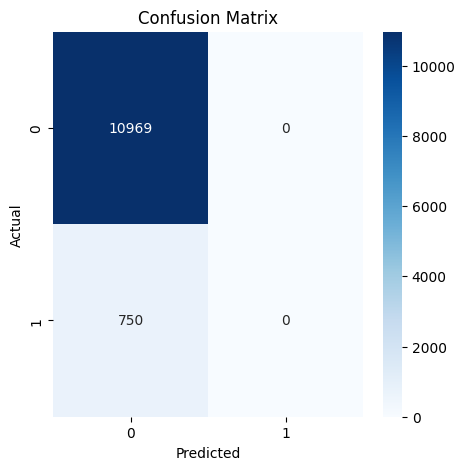

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [27]:
from sklearn.metrics import roc_auc_score

probs = model.predict_proba(X_test)[:, 1]  # 取「預測為 1」的機率
auc = roc_auc_score(y_test, probs)
print("AUC-ROC Score:", auc)

AUC-ROC Score: 0.5820777342206827


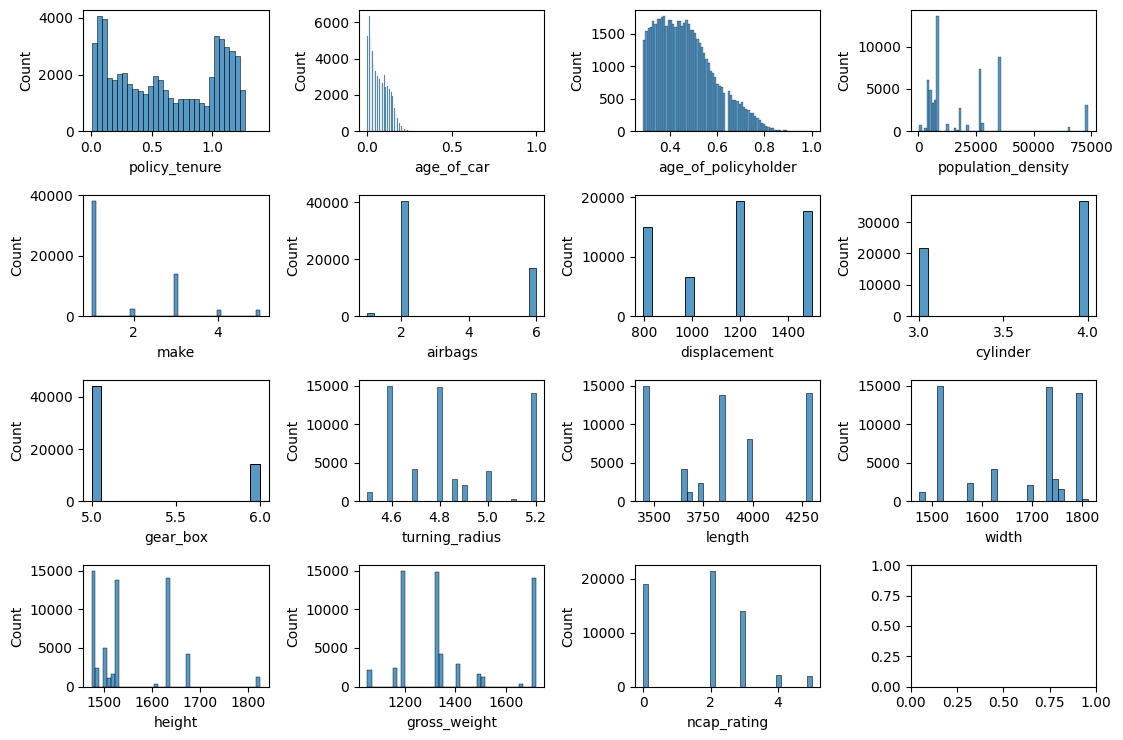

In [ ]:
# 以直方圖查看數值型欄位的分佈狀況
num_features = []
for col in df.columns:
  if not "is_" in col:
    if df[col].dtype in ("int64", "float64"):
      num_features.append(col)
num_features
len(num_features)
fig, axes = plt.subplots(4, 4, figsize=(11.33, 7.5))
axes = axes.flatten()
for i, col in enumerate(num_features):
  sns.histplot(data=df, x=col, ax=axes[i])

plt.tight_layout()



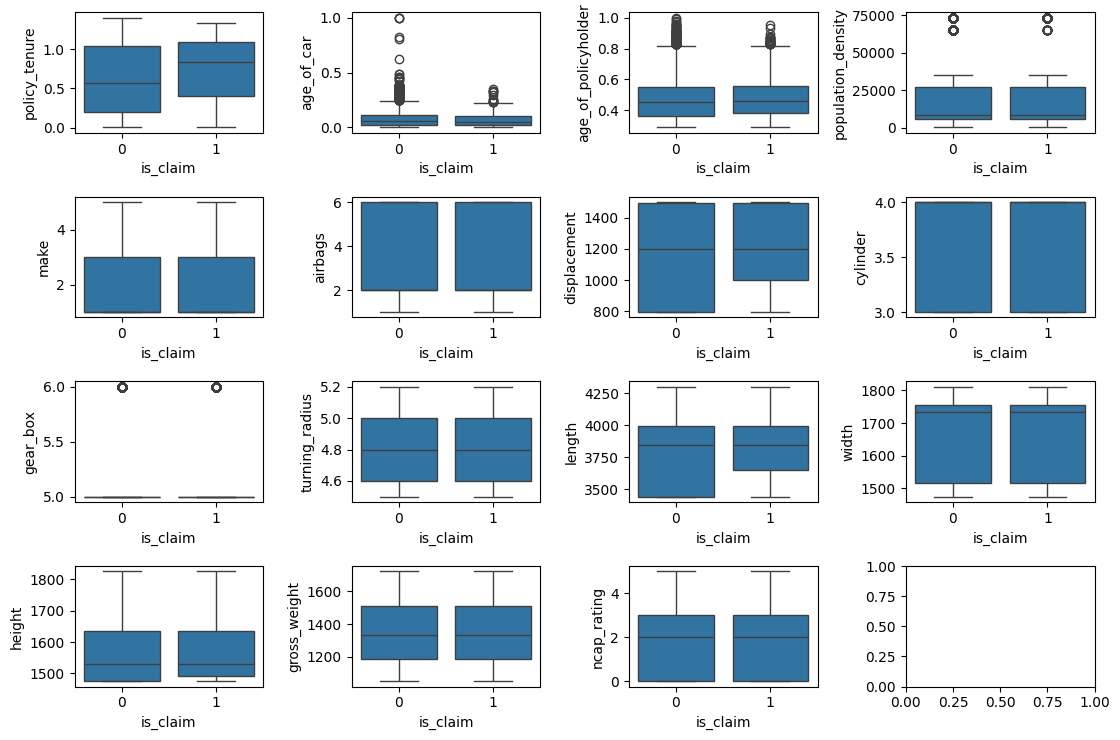

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(11.3, 7.5))
axes = axes.flatten()

for i, col in enumerate(num_features):
  sns.boxplot(data=df, x="is_claim", y=col, ax=axes[i])
plt.tight_layout()

